# NBA Game Predictor Model
### CMPE 257 Project
Authors: Kaushika Uppu, Miranda Billawala, Yun Ei Hlaing, Iris Cheung

## Imports

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

## NBA Game Data

First, we load in all of the NBA game data from the CSV file. Exact code for gathering data is in a separate file and use the nba_api file. Only games from the 1985-1986 season and afterward are loaded in as the seasons before that are missing a very significant portion of the game statistics' data. 

In [2]:
all_stats = pd.read_csv('all_game_stats.csv')
all_stats.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,AST_RANK,TOV_RANK,STL_RANK,BLK_RANK,BLKA_RANK,PF_RANK,PFD_RANK,PTS_RANK,PLUS_MINUS_RANK,AVAILABLE_FLAG
0,21985.0,1610612737,ATL,Atlanta Hawks,28500933,1986-04-12,ATL vs. IND,W,240.0,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21985.0,1610612737,ATL,Atlanta Hawks,28500921,1986-04-10,ATL vs. NJN,W,240.0,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21985.0,1610612737,ATL,Atlanta Hawks,28500908,1986-04-08,ATL vs. CHI,W,240.0,52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21985.0,1610612737,ATL,Atlanta Hawks,28500891,1986-04-05,ATL @ CHI,L,240.0,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21985.0,1610612737,ATL,Atlanta Hawks,28500884,1986-04-04,ATL @ WAS,L,265.0,54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
all_stats.shape

(89542, 59)

## Data Cleaning and Pre-Processing

### Inputting Missing Values

As shown below, there are a number of rows with the `SEASON_YEAR` variable missing. Therefore, we will calculate the `SEASON_YEAR` based on the `GAME_DATE` variable and fill in those missing values.

In [4]:
all_stats['SEASON_YEAR'].isna().sum()

np.int64(23370)

In [5]:
for index, row in all_stats.iterrows():
    if pd.isna(all_stats.iloc[index]['SEASON_YEAR']):
        year_index = all_stats.iloc[index]['GAME_DATE'].find('-')
        year = all_stats.iloc[index]['GAME_DATE'][:year_index]
        month = all_stats.iloc[index]['GAME_DATE'][year_index+1:year_index+3]
        if int(month) >= 10:
            season = str(int(year)) + "-" + str(int(year)+1)[2:]
        else:
            season = str(int(year)-1) + "-" + str(int(year))[2:]
        all_stats.loc[index, 'SEASON_YEAR'] = season

In [6]:
len(all_stats[all_stats['SEASON_YEAR'].isna()])

0

Then, we convert the `SEASON_YEAR` variable into an integer variable of just the year that the season started (e.g., 1985 for '1985-86').

In [7]:
all_stats['SEASON_YEAR'] = all_stats['SEASON_YEAR'].str.split('-').str[0].astype(int)

A look at the new `SEASON_YEAR` column:

In [8]:
all_stats[['SEASON_YEAR']].sample(10)

,SEASON_YEAR
50376,2017
21878,2001
59006,2007
19813,2015
54741,1993
76767,2005
83929,1987
31255,2001
29356,2016
16192,2008


In [9]:
all_stats.isna().sum()

SEASON_ID            66172
TEAM_ID                  0
TEAM_ABBREVIATION        0
TEAM_NAME                0
GAME_ID                  0
GAME_DATE                0
MATCHUP                  0
WL                       0
MIN                      0
FGM                      0
FGA                      0
FG_PCT                   0
FG3M                     0
FG3A                     0
FG3_PCT                475
FTM                      0
FTA                      0
FT_PCT                   0
OREB                     0
DREB                     0
REB                      0
AST                      0
STL                      0
BLK                      0
TOV                      0
PF                       0
PTS                      0
PLUS_MINUS               0
VIDEO_AVAILABLE      66172
SEASON_YEAR              0
BLKA                 23370
PFD                  23370
GP_RANK              23370
W_RANK               23370
L_RANK               23370
W_PCT_RANK           23370
MIN_RANK             23370
F

As seen above, there are also 475 missing values in the `FG3_PCT` column. Taking a look at the `FG3A` column for the rows with missing values, we can see that they are all 0, hence why the `FG3_PCT` column has NaN values for these rows. Therefore, we filled the missing values with 0.

In [10]:
all_stats[all_stats['FG3_PCT'].isna()]['FG3A'].unique()

array([0])

In [11]:
missing_indicies = all_stats[all_stats['FG3_PCT'].isna()].index

In [12]:
for i in missing_indicies:
    all_stats.loc[i, 'FG3_PCT'] = 0

### Dropping Irrelevant Columns

There are a lot of other columns in the dataset that have a significant number of missing values. We will drop these columns, as most of them are also rankings for stats that are already in the dataset.

In [13]:
to_drop = ['SEASON_ID', 'GAME_ID', 'VIDEO_AVAILABLE', 'GP_RANK', 'W_RANK', 'L_RANK', 'W_PCT_RANK', 'MIN_RANK', 'FGM_RANK', 'FGA_RANK',
           'FG_PCT_RANK', 'FG3M_RANK', 'FG3A_RANK', 'FG3_PCT_RANK', 'FTM_RANK', 'FTA_RANK', 'FT_PCT_RANK', 'OREB_RANK',
           'DREB_RANK', 'REB_RANK', 'AST_RANK', 'TOV_RANK', 'STL_RANK', 'BLK_RANK', 'BLKA_RANK', 'PF_RANK', 'PFD_RANK',
           'PTS_RANK', 'PLUS_MINUS_RANK', 'AVAILABLE_FLAG', 'BLKA', 'PFD' ]

In [14]:
all_stats_cleaned = all_stats.drop(columns = to_drop)

In [15]:
all_stats_cleaned.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
0,1610612737,ATL,Atlanta Hawks,1986-04-12,ATL vs. IND,W,240.0,38,88,0.432,...,39,59,22,6,3,12.0,21,108,17.0,1985
1,1610612737,ATL,Atlanta Hawks,1986-04-10,ATL vs. NJN,W,240.0,44,87,0.506,...,27,42,30,15,5,22.0,26,126,9.0,1985
2,1610612737,ATL,Atlanta Hawks,1986-04-08,ATL vs. CHI,W,240.0,52,98,0.531,...,25,42,33,13,6,10.0,22,131,13.0,1985
3,1610612737,ATL,Atlanta Hawks,1986-04-05,ATL @ CHI,L,240.0,40,76,0.526,...,25,38,17,7,7,21.0,28,97,-5.0,1985
4,1610612737,ATL,Atlanta Hawks,1986-04-04,ATL @ WAS,L,265.0,54,100,0.540,...,28,45,24,6,7,14.0,37,129,-6.0,1985


### Fixing Team ID
Since Team ID seems to start at 1610612737, we are going to subtract this value from each `TEAM_ID` to get more readable numbers. And, we want to create a dictionary to hold team names. 

In [16]:
all_stats_cleaned['TEAM_ID'] = [(all_stats_cleaned.iloc[i, 0]-1610612737) for i in range(all_stats_cleaned.shape[0])]

In [17]:
all_stats_cleaned.sample(10)

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,MATCHUP,WL,MIN,FGM,FGA,FG_PCT,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
38504,12,MIL,Milwaukee Bucks,2016-10-26T00:00:00,MIL vs. CHA,L,48.0,39,92,0.424,...,36,46,23,4,5,8.0,22,96,-11.0,2016
74516,24,TOR,Toronto Raptors,2017-03-08T00:00:00,TOR @ NOP,W,48.0,36,76,0.474,...,34,42,21,6,6,12.0,18,94,7.0,2016
21749,7,GSW,Golden State Warriors,2001-03-10T00:00:00,GSW @ HOU,L,48.0,32,81,0.395,...,28,39,16,12,6,20.0,19,81,-5.0,2000
57977,19,PHX,Phoenix Suns,1994-12-02,PHX @ BOS,W,240.0,42,93,0.452,...,26,43,25,6,4,13.0,14,107,5.0,1994
26791,9,LAC,Los Angeles Clippers,1986-04-01,LAC @ UTH,W,240.0,44,81,0.543,...,35,43,25,4,12,21.0,28,113,4.0,1985
51105,17,IND,Indiana Pacers,1988-02-24,IND vs. MIL,L,240.0,40,90,0.444,...,39,52,19,4,5,13.0,29,94,-3.0,1987
52825,17,IND,Indiana Pacers,2008-12-12T00:00:00,IND @ DET,L,48.0,39,69,0.565,...,31,38,27,8,2,21.0,21,110,-4.0,2008
50804,16,ORL,Orlando Magic,2022-12-05T00:00:00,ORL vs. MIL,L,48.0,34,93,0.366,...,37,52,21,8,2,14.0,19,102,-7.0,2022
80292,26,MEM,Memphis Grizzlies,2021-03-17T00:00:00,MEM vs. MIA,W,48.0,30,85,0.353,...,42,50,22,5,4,10.0,17,89,4.0,2020
19508,6,DEN,Denver Nuggets,2012-04-13T00:00:00,DEN @ LAL,L,48.0,41,92,0.446,...,22,40,20,15,2,15.0,23,97,-6.0,2011


We then want to create a dictionary so we can determine ID from abbreviation and vice versa.

In [18]:
team_id_to_abb = {} # dictionary to convert from team_id to team_abbreviation
team_abb_to_id = {} # dictionary to convert from team_abbreviation to team_id

teams = (all_stats_cleaned[['TEAM_ID', 'TEAM_ABBREVIATION']]).drop_duplicates()

for index, row in teams.iterrows() :
    if row['TEAM_ID'] not in team_id_to_abb.keys():
        team_id_to_abb[row['TEAM_ID']] = []
    team_id_to_abb[row['TEAM_ID']].append(row['TEAM_ABBREVIATION'])
    team_abb_to_id[row['TEAM_ABBREVIATION']] = row['TEAM_ID']

### Cleaning Matchup Column

Next, the `MATCHUP` column contains information on the opponent as well as if it was a home or away game. To make sure these features are clear for the model, we split this information into two separate columns: `OPPONENT` and `HOME`. `HOME` is a binary variable where a value of 1 indicates a home game and a value of 0 indicates an away game. `OPPONENT` contains the team abbreviation of the other team.

Creating `HOME` variable:

In [19]:
home_away = [0 if '@' in all_stats_cleaned['MATCHUP'].iloc[i] else 1 for i in range(len(all_stats_cleaned))]

In [20]:
all_stats_cleaned.insert(5, 'HOME', home_away)

Creating `OPPONENT` and `OPPONENT_ID` variable:

In [21]:
opp = [all_stats_cleaned['MATCHUP'].iloc[i][-3:] for i in range(len(all_stats_cleaned))]

In [22]:
all_stats_cleaned.insert(6, 'OPPONENT', opp)

Finally, we got rid of the `MATCHUP` column as it now contains redundant information

In [23]:
all_stats_cleaned = all_stats_cleaned.drop(columns = ['MATCHUP'])

In [24]:
all_stats_cleaned.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,HOME,OPPONENT,WL,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
0,0,ATL,Atlanta Hawks,1986-04-12,1,IND,W,240.0,38,88,...,39,59,22,6,3,12.0,21,108,17.0,1985
1,0,ATL,Atlanta Hawks,1986-04-10,1,NJN,W,240.0,44,87,...,27,42,30,15,5,22.0,26,126,9.0,1985
2,0,ATL,Atlanta Hawks,1986-04-08,1,CHI,W,240.0,52,98,...,25,42,33,13,6,10.0,22,131,13.0,1985
3,0,ATL,Atlanta Hawks,1986-04-05,0,CHI,L,240.0,40,76,...,25,38,17,7,7,21.0,28,97,-5.0,1985
4,0,ATL,Atlanta Hawks,1986-04-04,0,WAS,L,265.0,54,100,...,28,45,24,6,7,14.0,37,129,-6.0,1985


### Cleaning up Game Date Column

In order for the model to interpret the date of the games, we decided to change the `GAME_DATE` column into datetime objects rather than keeping them as strings.

In [25]:
all_stats_cleaned['GAME_DATE'] = pd.to_datetime(all_stats_cleaned['GAME_DATE'], yearfirst=True, format='ISO8601')

A look at the new `GAME_DATE` column:

In [26]:
all_stats_cleaned[['GAME_DATE']].sample(10)

,GAME_DATE
1627,2006-03-17
11705,1991-11-29
41607,2020-12-23
82225,2006-01-25
10970,2021-11-08
71425,2007-01-19
62916,2018-01-18
3646,1992-02-21
39388,1994-04-24
26583,2022-01-03


### Cleaning up WL Column

The `WL` column states whether the team won or lost that specific game. However, we decided to convert this information into a binary variable `WIN`, which holds 1 for a win and 0 for a loss.

In [27]:
win = [1 if all_stats_cleaned.iloc[i]['WL'] == 'W' else 0 for i in range(len(all_stats_cleaned))]

In [28]:
all_stats_cleaned.insert(6, 'WIN', win)

Dropping `WL` column:

In [29]:
all_stats_cleaned = all_stats_cleaned.drop(columns = ['WL'])

In [30]:
all_stats_cleaned.head()

,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,HOME,OPPONENT,WIN,MIN,FGM,FGA,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR
0,0,ATL,Atlanta Hawks,1986-04-12,1,IND,1,240.0,38,88,...,39,59,22,6,3,12.0,21,108,17.0,1985
1,0,ATL,Atlanta Hawks,1986-04-10,1,NJN,1,240.0,44,87,...,27,42,30,15,5,22.0,26,126,9.0,1985
2,0,ATL,Atlanta Hawks,1986-04-08,1,CHI,1,240.0,52,98,...,25,42,33,13,6,10.0,22,131,13.0,1985
3,0,ATL,Atlanta Hawks,1986-04-05,0,CHI,0,240.0,40,76,...,25,38,17,7,7,21.0,28,97,-5.0,1985
4,0,ATL,Atlanta Hawks,1986-04-04,0,WAS,0,265.0,54,100,...,28,45,24,6,7,14.0,37,129,-6.0,1985


### Merging Home and Away Team Stats Into One Row

Currently, each game is represented by two separate rows in the dataset - one for the home team and one for the away team. To make the data more clear, we decided to combine the two rows into a single row with statistics for both teams. Since predicting with our model will pass one set order of team one and team two (i.e. Lakers as Team One, Warriors as Team Two), we want to make sure that the model realizes games with the Lakers as Team Two and Warriors as Team One are more similar than may appear by the data. To do this, we will duplicate the rows and flip the teams. Then, we will have each game listed twice with the teams flipped. 

Firstly, we split the dataset into two : home games and away games. Then, we performed a join on these two datasets, matching each home team with its corresponding opponent based on the same dates. 

In [31]:
home = all_stats_cleaned[all_stats_cleaned.HOME == 1]
away = all_stats_cleaned[all_stats_cleaned.HOME == 0]

In [32]:
combined_stats_home = pd.merge(home, away, 
                          left_on=['GAME_DATE', 'OPPONENT'], 
                          right_on=['GAME_DATE', 'TEAM_ABBREVIATION'],
                          suffixes=('_ONE', '_TWO'))
combined_stats_away = pd.merge(away, home, 
                          left_on=['GAME_DATE', 'OPPONENT'], 
                          right_on=['GAME_DATE', 'TEAM_ABBREVIATION'],
                          suffixes=('_ONE', '_TWO'))

combined_stats = pd.concat([combined_stats_home, combined_stats_away], ignore_index = True)

In [33]:
combined_stats.head(5)

,TEAM_ID_ONE,TEAM_ABBREVIATION_ONE,TEAM_NAME_ONE,GAME_DATE,HOME_ONE,OPPONENT_ONE,WIN_ONE,MIN_ONE,FGM_ONE,FGA_ONE,...,DREB_TWO,REB_TWO,AST_TWO,STL_TWO,BLK_TWO,TOV_TWO,PF_TWO,PTS_TWO,PLUS_MINUS_TWO,SEASON_YEAR_TWO
0,0,ATL,Atlanta Hawks,1986-04-12,1,IND,1,240.0,38,88,...,36,43,22,7,3,13.0,33,91,-17.0,1985
1,0,ATL,Atlanta Hawks,1986-04-10,1,NJN,1,240.0,44,87,...,30,44,25,10,1,24.0,30,117,-9.0,1985
2,0,ATL,Atlanta Hawks,1986-04-08,1,CHI,1,240.0,52,98,...,35,44,29,5,1,17.0,26,118,-13.0,1985
3,0,ATL,Atlanta Hawks,1986-04-01,1,WAS,1,240.0,41,90,...,30,46,19,10,6,17.0,22,91,-16.0,1985
4,0,ATL,Atlanta Hawks,1986-03-29,1,CLE,0,240.0,36,84,...,25,33,31,8,5,16.0,32,123,18.0,1985


Comparing the number of rows in the combined dataset to the original shows that the dataset row have been reduced by half, as each game is now represented by a single row instead of two.

In [34]:
combined_stats.shape

(89542, 55)

In [35]:
all_stats_cleaned.shape

(89542, 28)

In [36]:
combined_stats.columns

Index(['TEAM_ID_ONE', 'TEAM_ABBREVIATION_ONE', 'TEAM_NAME_ONE', 'GAME_DATE',
       'HOME_ONE', 'OPPONENT_ONE', 'WIN_ONE', 'MIN_ONE', 'FGM_ONE', 'FGA_ONE',
       'FG_PCT_ONE', 'FG3M_ONE', 'FG3A_ONE', 'FG3_PCT_ONE', 'FTM_ONE',
       'FTA_ONE', 'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE', 'AST_ONE',
       'STL_ONE', 'BLK_ONE', 'TOV_ONE', 'PF_ONE', 'PTS_ONE', 'PLUS_MINUS_ONE',
       'SEASON_YEAR_ONE', 'TEAM_ID_TWO', 'TEAM_ABBREVIATION_TWO',
       'TEAM_NAME_TWO', 'HOME_TWO', 'OPPONENT_TWO', 'WIN_TWO', 'MIN_TWO',
       'FGM_TWO', 'FGA_TWO', 'FG_PCT_TWO', 'FG3M_TWO', 'FG3A_TWO',
       'FG3_PCT_TWO', 'FTM_TWO', 'FTA_TWO', 'FT_PCT_TWO', 'OREB_TWO',
       'DREB_TWO', 'REB_TWO', 'AST_TWO', 'STL_TWO', 'BLK_TWO', 'TOV_TWO',
       'PF_TWO', 'PTS_TWO', 'PLUS_MINUS_TWO', 'SEASON_YEAR_TWO'],
      dtype='object')

#### Dropping Duplicate Columns 

After merging the rows, there are some columns that appear twice or are now unneccessary to the dataset. These columns include `MIN_ONE`/`MIN_TWO` (length of game in minutes), `SEASON_YEAR_ONE`/`SEASON_YEAR_TWO`, `OPPONENT_ONE` and `OPPONENT_TWO`.

We first checked if the `MIN_ONE` and `MIN_TWO` for each row has the same values. As seen below, there are 24 games where the minutes differed slightly. However, since the difference did not seem to be significant, we decided to retain one column and rename it `MIN`.

In [37]:
(combined_stats['MIN_ONE'] != combined_stats['MIN_TWO']).sum()

np.int64(48)

In [38]:
combined_stats[combined_stats['MIN_ONE'] != combined_stats['MIN_TWO']][['MIN_ONE','MIN_TWO']]

,MIN_ONE,MIN_TWO
455,48.000000,47.448000
3612,48.000000,47.637333
6039,48.000000,47.906667
7608,48.000000,47.517333
12325,48.000000,47.357667
19857,48.000000,47.599333
24354,48.000000,47.813333
25946,48.000000,47.456000
30645,53.000000,52.906667
32173,47.881000,48.000000


In [39]:
combined_stats = combined_stats.drop(columns = ['MIN_TWO', 'OPPONENT_ONE', 'OPPONENT_TWO', 'SEASON_YEAR_ONE'])
combined_stats.rename(columns={'MIN_ONE': 'MIN', 'SEASON_YEAR_TWO': 'SEASON_YEAR'}, inplace=True)

In [40]:
combined_stats.columns

Index(['TEAM_ID_ONE', 'TEAM_ABBREVIATION_ONE', 'TEAM_NAME_ONE', 'GAME_DATE',
       'HOME_ONE', 'WIN_ONE', 'MIN', 'FGM_ONE', 'FGA_ONE', 'FG_PCT_ONE',
       'FG3M_ONE', 'FG3A_ONE', 'FG3_PCT_ONE', 'FTM_ONE', 'FTA_ONE',
       'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE', 'AST_ONE', 'STL_ONE',
       'BLK_ONE', 'TOV_ONE', 'PF_ONE', 'PTS_ONE', 'PLUS_MINUS_ONE',
       'TEAM_ID_TWO', 'TEAM_ABBREVIATION_TWO', 'TEAM_NAME_TWO', 'HOME_TWO',
       'WIN_TWO', 'FGM_TWO', 'FGA_TWO', 'FG_PCT_TWO', 'FG3M_TWO', 'FG3A_TWO',
       'FG3_PCT_TWO', 'FTM_TWO', 'FTA_TWO', 'FT_PCT_TWO', 'OREB_TWO',
       'DREB_TWO', 'REB_TWO', 'AST_TWO', 'STL_TWO', 'BLK_TWO', 'TOV_TWO',
       'PF_TWO', 'PTS_TWO', 'PLUS_MINUS_TWO', 'SEASON_YEAR'],
      dtype='object')

## Exploratory Data Analysis
In this section, we take a look at the data to better understand the different features as well as any possible trends.

### Rolling Average vs. Actual Value

In [41]:
def rollingAvg(team_id, feature_name, rolling_window = 3, season = 0, plot = True) :
    """
    This function takes a team and feature and calculate the rolling average (not including the game on a given date)
    and the actual value of that feature on the day. It can visualize this comparison and returns the RMSE between the 
    rolling average and actual value.

    Inputs:
    team_id: integer from 0-29 representing a team (required)
    feature_name: string of a column of integer values from the dataset (required)
    rolling_window: how many days to average over (default = 3)
    season: season we are looking at (defaults to most current season)
    plot: whether or not to plot the function (default = True)

    Output: RMSE between predicted value (rolling average) and actual value
    """
    if (season < all_stats_cleaned['SEASON_YEAR'].min()) or (season > all_stats_cleaned['SEASON_YEAR'].max()) :
        season = all_stats_cleaned['SEASON_YEAR'].max()
        
    data = all_stats_cleaned[(all_stats_cleaned['TEAM_ID'] == team_id) & (all_stats_cleaned['SEASON_YEAR'] == season)]
    data = data[['GAME_DATE', feature_name]].sort_values(by='GAME_DATE')
    data['SHIFTED'] = data[feature_name].shift(1)
    data['ROLLING_AVG'] = data['SHIFTED'].rolling(window = rolling_window).mean()
    if plot :
        plt.figure(figsize=(10,5))
        plt.plot(data['GAME_DATE'], data['ROLLING_AVG'], marker = 'o', linestyle = '-', label = "Rolling Avg")
        plt.plot(data['GAME_DATE'], data[feature_name], marker = 'o', linestyle = '-', label = "Actual Value")
        plt.xlabel("Date")
        plt.ylabel("Average Points")
        plt.title("Rolling Average Points Over Time")
        plt.legend()
        plt.show()

    # Calculate RMSE
    data = data.dropna()
    error = np.sqrt(np.mean((data[feature_name].values-data['ROLLING_AVG'].values) ** 2))
    return error

The function above takes a team ID and a specific feature (with optional arguments of specifying the rolling window, season of interest, and to plot or not) and finds the rolling average. Our rolling average calculates a predicted value for the next game and the graph plots the prediction against the actual result. The function returns the error calculated by RMSE of a specific rolling window. We can use this to see how predictive previous games are of team performance in an upcoming game and decide what a good window might be.

Below, we test rolling windows from 1 to 20 with the option to adjust the season, team, and feature. This can be used later on when building test examples for the model.

Best Window: 11


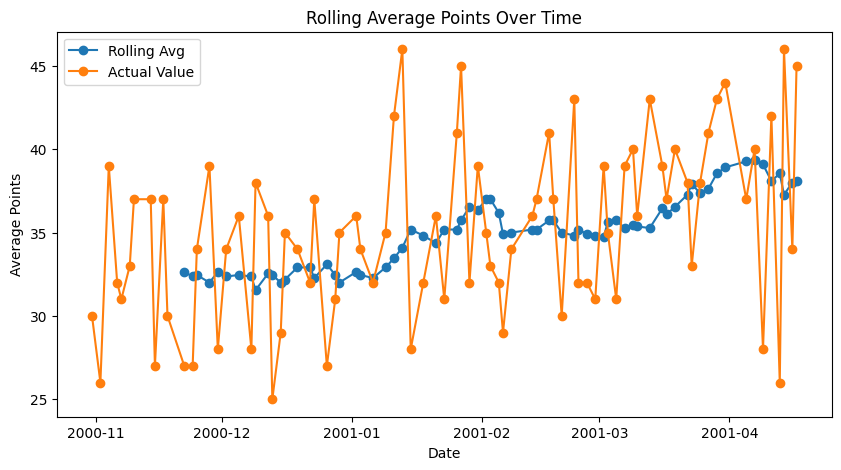

np.float64(4.945636247321063)

In [42]:
min_error = None
best_window = 0
team = 0
feature = 'FGM'
season = 2000

for i in range(1, 20) :
    rmse = rollingAvg(team, feature, i, season, False)
    if min_error is None or rmse < min_error:
        min_error = rmse
        best_window = i

print("Best Window:", best_window)
rollingAvg(team, feature, best_window, season)

The code above finds that the best window for the `FGM` variable is 11. It then visualizes the predictions agains the actual values and provides the RMSE of them. 

### Team vs. Team Performance
We look at a heatmap showing the win percentages between teams to see how teams perform.

In [43]:
def calculateWinMatrix(start_season = all_stats_cleaned['SEASON_YEAR'].min(), end_season = all_stats_cleaned['SEASON_YEAR'].max()) :
    """
    This function takes a range of seasons and calculates the win percentages of the a team against all other teams for all games
    occuring within the provided season. Each row represents the win percentages a team.

    Inputs:
    start_season: first season to look at (default first recorded season)
    end_season: last season to consider (default most recent season)

    Output: Numpy matrix containing win percentages for team by row.
    """
    
    num_teams = len(team_id_to_abb)
    np_win_matrix = np.zeros((num_teams, num_teams))
    for team_one in range(num_teams):
        for team_two, team_two_abb in team_id_to_abb.items() :
            if team_one == team_two : continue
            games = wins = 0
            for x in team_two_abb :
                matches = all_stats_cleaned[(all_stats_cleaned['TEAM_ID'] == team_one) & (all_stats_cleaned['OPPONENT'] == x) & (all_stats_cleaned['SEASON_YEAR'].between(start_season, end_season)) ]
                games += len(matches)
                wins += len(matches[matches['WIN'] == 1])
        
            np_win_matrix[team_one][team_two] = wins / games
    return np_win_matrix


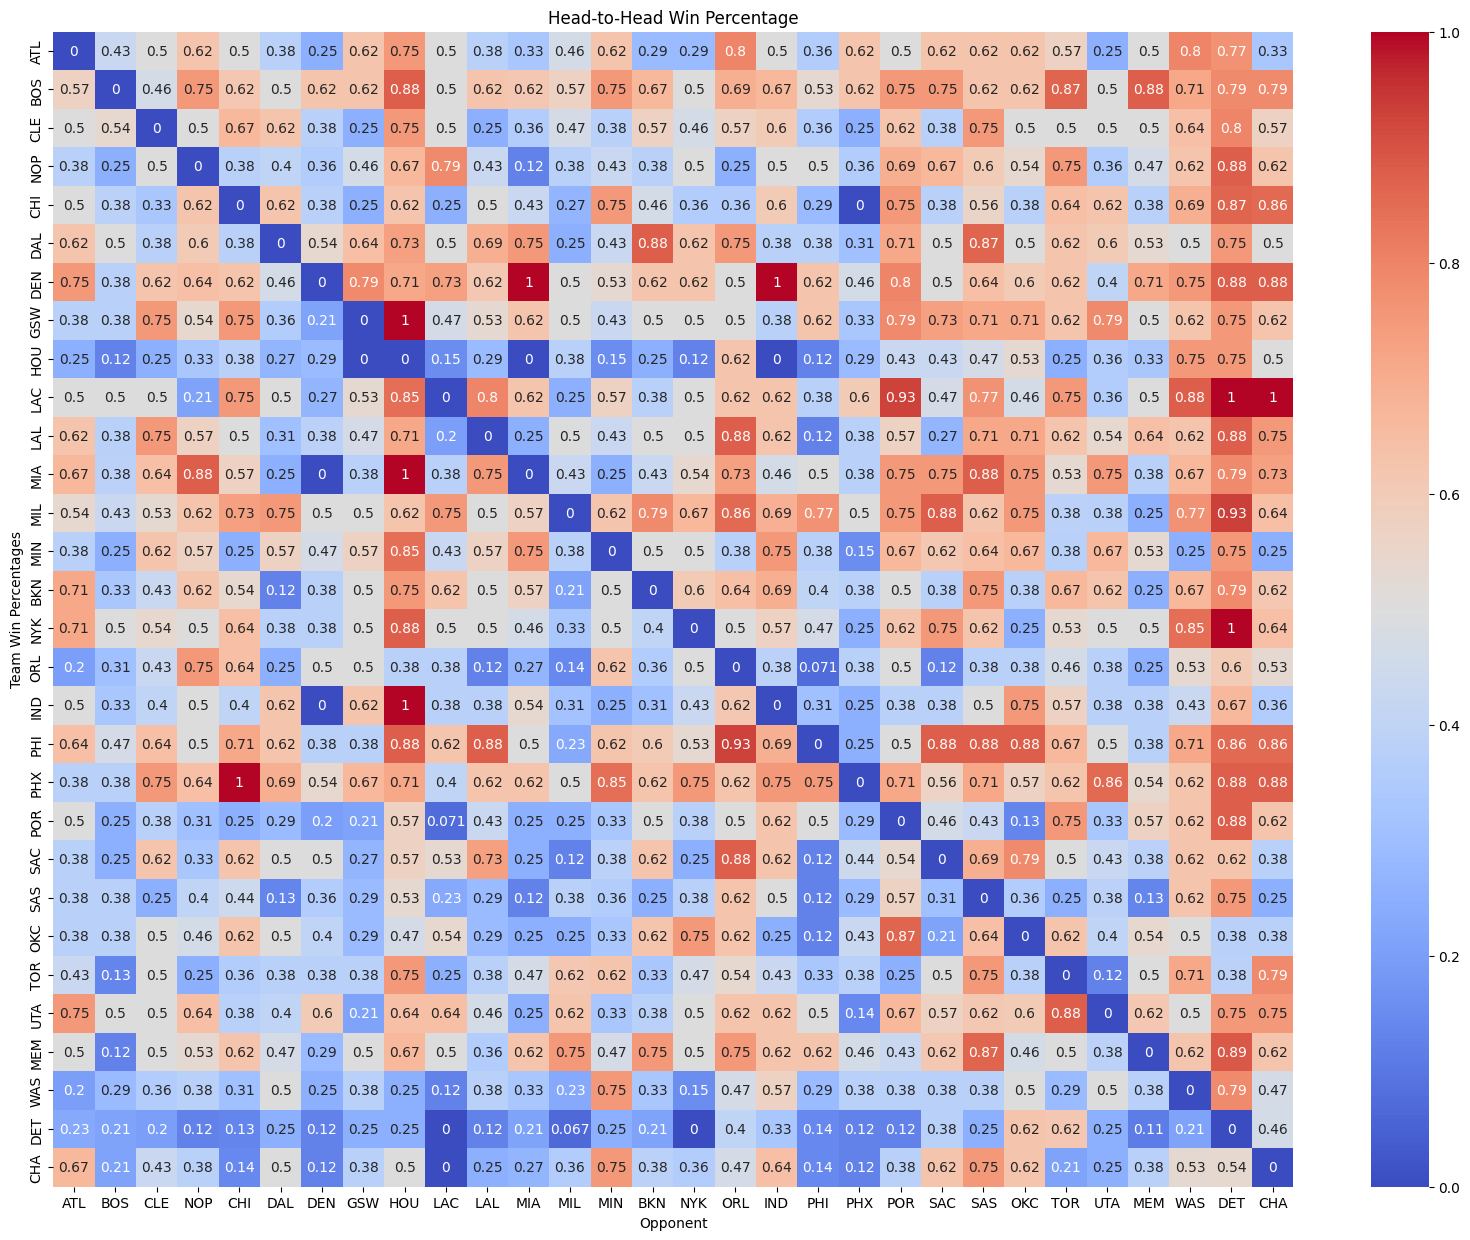

In [44]:
np_win_matrix = calculateWinMatrix(2020, 2025)
teams = [team_id_to_abb[i][-1] for i in team_id_to_abb]
plt.figure(figsize =(20,15))
sns.heatmap(np_win_matrix, annot=True, cmap="coolwarm", xticklabels=teams, yticklabels=teams) 
plt.xlabel("Opponent")
plt.ylabel("Team Win Percentages")
plt.title("Head-to-Head Win Percentage")
plt.show()

Looking at the heatmap above, we can see that certain teams perform far better and worse than others. For example, DET loses more games than wins against nearly every team in the range from 2020 to 2025. The same goes for Washington. However, Washington seems to fare especially well against MIN despite MIN generally having win percentages above 50%. This tells us that Washington may perform especially well against MIN and increase their probability of winning despite generally losing their games. 

### Home Court Advantage
Another important factor is home-court advantage (i.e. increased chance of winning due to playing at home). We want to observe how this affects teams. Since teams typically play half their games at home and half away (playing each team twice during a season, once at home at once away), we can forgo calculating home wins / total home games and away wins / total away games and instead just look at how many wins were home. 

In [45]:
def homeWins(team_id) :
    """
    This function takes a team ID and calculates the percentages of wins that are at home each season. 
    Then, we graph the values on a bar graph.

    Inputs:
    team_id: team ID, required
    """
    start = all_stats_cleaned['SEASON_YEAR'].min()
    end = all_stats_cleaned['SEASON_YEAR'].max()

    years = list(range(start, end+1))
    win_percentages = []
    games = all_stats_cleaned[all_stats_cleaned['TEAM_ID'] == team_id]

    for i in years :
        games_in_season = games[games['SEASON_YEAR'] == i]
        wins_in_season = games_in_season[games_in_season['WIN'] == 1]
        home_wins = wins_in_season[wins_in_season['HOME'] == 1]
        if len(wins_in_season) == 0 : 
            win_percentages.append(0)
        else :
            win_percentages.append(len(home_wins) / len(wins_in_season))

    team_abb = team_id_to_abb[team_id][-1]
    plt.bar(years, win_percentages)
    plt.xlabel('Year')
    plt.ylabel('Win Percentages At Home')
    plt.title(f'Win Percentages at Home for {team_abb} over the Years')
    plt.show()

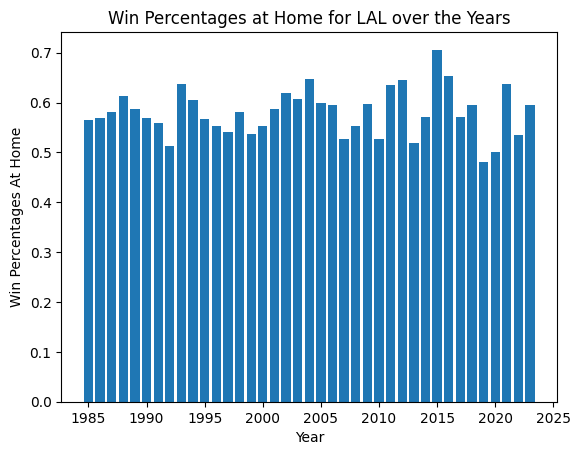

In [46]:
homeWins(10)

The above bargraph shows us that for the Los Angeles Lakers (LAL), the game being at home results in a slightly higher probability of winning. Looking at more teams, we will see that this trend continues, although perhaps not as strong as some may think. This indicates the model may find whether the game is home or away to be a significant factor. 

### Statistics in Games Won vs. Lost
We also want to see how values compare in games they won or lost. We can do that by graphing the averages over a season for games a specific team lost and won as follows. 

In [47]:
def winLossAverages(team_id, feature) :
    """
    This function takes a team ID and a feature and calculates the average value of that feature 
    for each season separated into games won or lost. This allows us to see how a value could be 
    used to predict if a team will win or not.
    """
    start = all_stats_cleaned['SEASON_YEAR'].min()
    end = all_stats_cleaned['SEASON_YEAR'].max()

    years = list(range(start, end+1))
    avg_for_wins = []
    avg_for_losses = []

    for y in years :
        games = all_stats_cleaned[all_stats_cleaned['SEASON_YEAR'] == y]
        wins = games[games['WIN'] == 1]
        losses = games[games['WIN'] == 0]

        avg_for_wins.append(wins[feature].mean())
        avg_for_losses.append(losses[feature].mean())

    plt.figure(figsize = (10, 5))
    plt.plot(years, avg_for_wins, linestyle = '-', label = "Games Won")
    plt.plot(years, avg_for_losses, linestyle = '-', label = "Games Lost")
    plt.xlabel("Seasons")
    plt.ylabel(f"Average {feature}")
    plt.title(f"Comparing Averages of {feature} For Games Won or Lost by {team_id_to_abb[team_id][-1]}")
    plt.legend()
    plt.show()

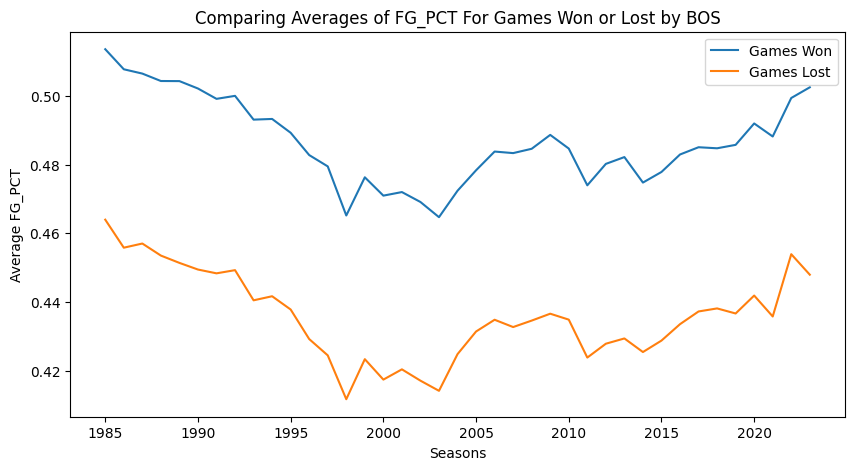

In [48]:
winLossAverages(1, 'FG_PCT')

Above we can see that field goal percentage is always significantly higher when games are won. Thus, when we expect a team to have a higher field goal percentage, they have a higher likelihood of winning. 

## Feature Engineering

In [49]:
all_stats_cleaned.columns

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'HOME',
       'OPPONENT', 'WIN', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'SEASON_YEAR'],
      dtype='object')

Features to add : 
1) Win streak
2) Win percentage
3) ELO Scores
4) EFG%
5) TS%

### Win Streak and Win Percentage

In [50]:
def add_win_streak_and_percentage(df, combined=False):
    """
    Input: Dataframe with team one and team two data for each game and boolean to check if dataframe is combined with both team data
    Output: New dataframe with added win streak and win percentage for both teams
    """
    team_date_stats = all_stats_cleaned[['TEAM_ID', 'GAME_DATE', 'WIN']].sort_values(by=['TEAM_ID', 'GAME_DATE']).reset_index(drop=True)
    team_date_stats['WIN_STREAK'] = 0
    team_date_stats['WIN_PERCENTAGE'] = 0.0
    
    for team_id, group in team_date_stats.groupby('TEAM_ID'):
        streak = 0
        wins = 0
        total_games = 0
        indices = group.index
    
        for i in range(len(indices)):
            idx = indices[i]
    
            # WIN STREAK
            team_date_stats.at[idx, 'WIN_STREAK'] = streak
    
            if team_date_stats.at[idx, 'WIN'] == 1:
                streak += 1
            else: 
                streak = 0
    
            # WIN PERCENTAGE
            if total_games == 0:
                team_date_stats.at[idx, 'WIN_PERCENTAGE'] = 0.0
            else: 
                team_date_stats.at[idx, 'WIN_PERCENTAGE'] = wins / total_games
    
            total_games += 1
            if team_date_stats.at[idx, 'WIN'] == 1:
                wins += 1

    if combined:
    # Join Win streak and Win percentage of team one and team two into the merged table
        team_date_stats.drop('WIN', axis=1, inplace=True)
        df = pd.merge(df, team_date_stats,
                              how='left', 
                              left_on = ['TEAM_ID_ONE', 'GAME_DATE'],
                              right_on=['TEAM_ID', 'GAME_DATE'])
        df.drop('TEAM_ID', axis=1, inplace=True)
        df.rename(columns = {'WIN_STREAK': 'WIN_STREAK_ONE',
                                     'WIN_PERCENTAGE': 'WIN_PERCENTAGE_ONE'}, inplace=True)
        df = pd.merge(df, team_date_stats,
                              how='left', 
                              left_on = ['TEAM_ID_TWO', 'GAME_DATE'],
                              right_on=['TEAM_ID', 'GAME_DATE'])
        df.drop('TEAM_ID', axis=1, inplace=True)
        df.rename(columns = {'WIN_STREAK': 'WIN_STREAK_TWO',
                                     'WIN_PERCENTAGE': 'WIN_PERCENTAGE_TWO'}, inplace=True)
    else:
        # Join Win streak and Win percentage into the dataframe
        team_date_stats.drop('WIN', axis=1, inplace=True)
        df = pd.merge(df, team_date_stats,
                              how='left', 
                              on = ['TEAM_ID', 'GAME_DATE'])
    
    return df

### ELO Score Before Current Game

In [51]:
def merge_opponent_points(df):
    df_opp = df[['TEAM_ABBREVIATION', 'GAME_DATE', 'PTS', 'TEAM_ID']].copy()
    merged_df = pd.merge(df, df_opp, 
                         how='left',
                          left_on=['GAME_DATE', 'OPPONENT'],
                            right_on=['GAME_DATE', 'TEAM_ABBREVIATION'],
                          suffixes=('', '_OPPONENT'))
    merged_df.drop(columns=['TEAM_ABBREVIATION_OPPONENT'], inplace=True)
    return merged_df

In [52]:
def add_elo_score(df, combined=False):
    """
    Input: Dataframe with team one and team two data for each game and boolean to check if dataframe is combined with both team data
    Output: New dataframe with elo scores for both teams added 
    """
    if combined:
        df['GAME_ID'] = df.apply(
        lambda row: '_'.join(sorted([str(row['TEAM_ID_ONE']), str(row['TEAM_ID_TWO'])]) + [str(row['GAME_DATE'])]),
        axis=1
    )
        df['ELO_ONE'] = np.nan
        df['ELO_TWO'] = np.nan
    else:
        df = merge_opponent_points(df)
        df['ELO'] = np.nan
        df['GAME_ID'] = df.apply(
        lambda row: '_'.join(sorted([str(row['TEAM_ID']), str(row['TEAM_ID_OPPONENT'])]) + [str(row['GAME_DATE'])]),
        axis=1
    )
    
    team_elos = {} # to use for checking if a team has appeared and track team last elo scores
    team_last_season = {} # to track last seasons of teams
    processed_games = set() # to track game id - handle duplicate game columns
    elo_map = {} # for faster computation
    df = df.sort_values(by='GAME_DATE').reset_index(drop=True)
    
    for i,row in df.iterrows():
        season = row['SEASON_YEAR']
        game_id = row['GAME_ID']

        if game_id in processed_games:
            continue
        processed_games.add(game_id)

        if combined:
            team_one, team_two = row['TEAM_ID_ONE'], row['TEAM_ID_TWO']
            points_one, points_two = row['PTS_ONE'], row['PTS_TWO']
            home_one = row['HOME_ONE']
        
            # Season adjustment formula for ELO : New Season ELO = 0.75 * Last Season ELO + 0.25 * Mean ELO, Mean ELO = 1505
            for team in [team_one, team_two]:
                # check if team has not appeared yet in the dataset
                if team not in team_elos:
                    team_elos[team] = 1505 
                    team_last_season[team] = season
                # check for new season, if yes, apply season adjustment
                elif team_last_season[team] != season:
                    team_elos[team] = 0.75 * team_elos[team] + 0.25 * 1505
                    team_last_season[team] = season
        
            # elo scores before game
            elo_one = team_elos[team_one]
            elo_two = team_elos[team_two]
        
            # Add 100 score to home team
            if home_one == 1:
                elo_one_after_home_adv = elo_one + 100 
                elo_two_after_home_adv = elo_two
            else:
                elo_one_after_home_adv = elo_one 
                elo_two_after_home_adv = elo_two + 100
        
            # Expected score of game formula : exp = 1/ (1+10^((ELO two after home advantage - ELO one after home advantage) / 400))
            exp = 1/ (1+10**((elo_two_after_home_adv - elo_one_after_home_adv) / 400))
        
            actual = 1 if points_one > points_two else 0
            margin_of_victory = abs(points_one - points_two)
        
            # Margin of Victory Multiplier formula : ((MOV + 3) ** 0.8) / (7.5 + 0.006 * (Elo team one - Elo team two))
            MOVM = ((margin_of_victory + 3) ** 0.8) / (7.5 + 0.006 * (elo_one - elo_two))
        
            # change in ELO: K * MOVM * (actual - exp), k -> attenuation factor -> higher means elo score adjusts quickly to changes in strength of team
            K = 20 # 20 is optimal for nba 
            change = K * MOVM * (actual - exp)
    
            # Update data for ELO ratings
            team_elos[team_one] += change
            team_elos[team_two] -= change
        
            # store elo score for game id at the table
            # df.at[i, 'ELO_ONE'] = elo_one
            # df.at[i, 'ELO_TWO'] = elo_two
            # df.loc[(df['GAME_ID'] == game_id) & df['TEAM_ID_ONE'] == team_two, 'ELO_ONE'] = elo_two
            # df.loc[(df['GAME_ID'] == game_id) & df['TEAM_ID_TWO'] == team_one, 'ELO_TWO'] = elo_one

            # store elo scores in dictionary
            elo_map[(game_id, team_one, team_two)] = elo_one
            elo_map[(game_id, team_two, team_one)] = elo_two
     
        else:
            team, team_opp = row['TEAM_ID'], row['TEAM_ID_OPPONENT']
            points_team, points_opp = row['PTS'], row['PTS_OPPONENT']
            home = row['HOME']
        
            # Season adjustment formula for ELO : New Season ELO = 0.75 * Last Season ELO + 0.25 * Mean ELO, Mean ELO = 1505
            for t in [team, team_opp]:
                # check if team has not appeared yet in the dataset
                if t not in team_elos:
                    team_elos[t] = 1505 
                    team_last_season[t] = season
                # check for new season, if yes, apply season adjustment
                elif team_last_season[t] != season:
                    team_elos[t] = 0.75 * team_elos[t] + 0.25 * 1505
                    team_last_season[t] = season
        
            # elo scores before game
            elo_team = team_elos[team]
            elo_opponent = team_elos[team_opp]
        
            # Add 100 score to home team
            if home == 1:
                elo_team_home = elo_team + 100 
                elo_opp_home = elo_opponent
            else:
                elo_team_home = elo_team 
                elo_opp_home = elo_opponent + 100
        
            # Expected score of game formula : exp = 1/ (1+10^((ELO two after home advantage - ELO one after home advantage) / 400))
            exp = 1/ (1+10**((elo_opp_home - elo_team_home) / 400))
        
            actual = 1 if points_team > points_opp else 0
            margin_of_victory = abs(points_team - points_opp)
        
            # Margin of Victory Multiplier formula : ((MOV + 3) ** 0.8) / (7.5 + 0.006 * (Elo team one - Elo team two))
            MOVM = ((margin_of_victory + 3) ** 0.8) / (7.5 + 0.006 * (elo_team - elo_opponent))
        
            # change in ELO: K * MOVM * (actual - exp), k -> attenuation factor -> higher means elo score adjusts quickly to changes in strength of team
            K = 20 # 20 is optimal for nba 
            change = K * MOVM * (actual - exp)

            # Update data for ELO ratings
            team_elos[team] += change
            team_elos[team_opp] -= change
        
            # store elo score for both row of game at the table
            # df.at[i, 'ELO'] = elo_team
            # df.loc[(df['GAME_ID'] == game_id) & df['TEAM_ID'] == team_opp, 'ELO'] = elo_opponent
            elo_map[(game_id, team)] = elo_team
            elo_map[(game_id, team_opp)] = elo_opponent

    # add data from elo dictionary into dataframe
    if not combined:
        df['ELO'] = df.apply(lambda x: elo_map.get((x['GAME_ID'], x['TEAM_ID']), np.nan), axis=1)
        df.drop(columns=['PTS_OPPONENT', 'TEAM_ID_OPPONENT'], axis=1, inplace=True)
    else: 
        df['ELO_ONE'] = df.apply(lambda x: elo_map.get((x['GAME_ID'], x['TEAM_ID_ONE'], x['TEAM_ID_TWO']), np.nan), axis=1)
        df['ELO_TWO'] = df.apply(lambda x: elo_map.get((x['GAME_ID'], x['TEAM_ID_TWO'], x['TEAM_ID_ONE']), np.nan), axis=1)
    df.drop(columns=['GAME_ID'], axis=1, inplace=True)
    
            
    return df                                   

In [53]:
# test for single team data
test_1 = add_win_streak_and_percentage(all_stats_cleaned)
test_1 = add_elo_score(test_1)
print(test_1.columns)
test_1[test_1['TEAM_ID'] == 14].head(5)

Index(['TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_DATE', 'HOME',
       'OPPONENT', 'WIN', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'SEASON_YEAR', 'WIN_STREAK',
       'WIN_PERCENTAGE', 'ELO'],
      dtype='object')


,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,HOME,OPPONENT,WIN,MIN,FGM,FGA,...,STL,BLK,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR,WIN_STREAK,WIN_PERCENTAGE,ELO
0,14,NJN,New Jersey Nets,1985-10-25,1,BOS,1,265.0,44,101,...,14,3,24.0,30,113,4.0,1985,0,0.000000,1505.000000
21,14,NJN,New Jersey Nets,1985-10-26,0,IND,0,240.0,31,79,...,10,0,19.0,28,92,-27.0,1985,1,1.000000,1509.552723
54,14,NJN,New Jersey Nets,1985-10-29,0,DET,0,240.0,40,98,...,6,4,20.0,39,107,-17.0,1985,0,0.500000,1494.776564
58,14,NJN,New Jersey Nets,1985-10-30,1,IND,1,315.0,55,121,...,14,6,20.0,36,147,9.0,1985,0,0.333333,1484.682913
82,14,NJN,New Jersey Nets,1985-11-01,1,PHL,1,240.0,45,86,...,15,6,21.0,20,106,4.0,1985,1,0.500000,1492.848408


In [54]:
# test for combined team and opponent data
test_2 = add_win_streak_and_percentage(combined_stats, True)
test_2 = add_elo_score(test_2, True)
test_2[test_2['TEAM_ID_ONE'] == 14].head(5)

,TEAM_ID_ONE,TEAM_ABBREVIATION_ONE,TEAM_NAME_ONE,GAME_DATE,HOME_ONE,WIN_ONE,MIN,FGM_ONE,FGA_ONE,FG_PCT_ONE,...,PF_TWO,PTS_TWO,PLUS_MINUS_TWO,SEASON_YEAR,WIN_STREAK_ONE,WIN_PERCENTAGE_ONE,WIN_STREAK_TWO,WIN_PERCENTAGE_TWO,ELO_ONE,ELO_TWO
11,14,NJN,New Jersey Nets,1985-10-25,1,1,265.0,44,101,0.436,...,27,109,-4.0,1985,0,0.000000,0,0.000000,1505.000000,1505.000000
16,14,NJN,New Jersey Nets,1985-10-26,0,0,240.0,31,79,0.392,...,27,119,27.0,1985,1,1.000000,0,0.000000,1509.552723,1505.000000
42,14,NJN,New Jersey Nets,1985-10-29,0,0,240.0,40,98,0.408,...,34,124,17.0,1985,0,0.500000,0,0.500000,1494.776564,1504.443525
59,14,NJN,New Jersey Nets,1985-10-30,1,1,315.0,55,121,0.455,...,35,138,-9.0,1985,0,0.333333,1,1.000000,1484.682913,1519.776159
80,14,NJN,New Jersey Nets,1985-11-01,1,1,240.0,45,86,0.523,...,20,102,-4.0,1985,1,0.500000,1,0.666667,1492.848408,1520.826747


### Effective Field Goal Percentage and True Shooting Percentage

In [55]:
def add_shooting_percentages(df):
    df['EFG%_ONE'] = (df['FGM_ONE'] + 1.5 * df['FG3M_ONE']) / df['FGA_ONE']
    df['EFG%_TWO'] = (df['FGM_TWO'] + 1.5 * df['FG3M_TWO']) / df['FGA_TWO']
    df['TS%_ONE'] = df['PTS_ONE'] / (2 * (df['FGA_ONE'] + 0.44 * df['FTA_ONE']))
    df['TS%_TWO'] = df['PTS_TWO'] / (2 * (df['FGA_TWO'] + 0.44 * df['FTA_TWO']))
    return df    

### Rolling Window Statistics

#### Adding additional columns to all_stats_cleaned -- READ HERE PLS
I had to change the function because I was working with all_stats_cleaned which is before we combine and doesn't have _one, _two. Also, I wasn't able to add ELO or win streaks since those functions were specifically tailored to the combined statistics and I was lazy. I think our best bet is to calculate all these values for the all_stats_cleaned dataframe, then create the combined dataset. The ELO and win streak scores do not need to be predicted using a rolling average, so if you just calculate those and add them to the all_stats_cleaned then my code should automatically include them. If you add some other value that should be predicted then either ask me or if my code makes sense, just add to it. 

In [56]:
def add_shooting_percentages(df):
    df['EFG%'] = (df['FGM'] + 1.5 * df['FG3M']) / df['FGA']
    df['TS%'] = df['PTS'] / (2 * (df['FGA'] + 0.44 * df['FTA']))
    return df    

# added shooting percentage
all_stats_cleaned = add_shooting_percentages(all_stats_cleaned)
# added win streak and win percentage
all_stats_cleaned = add_win_streak_and_percentage(all_stats_cleaned)
# added ELO score
all_stats_cleaned = add_elo_score(all_stats_cleaned)

In [57]:
cols = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'EFG%', 'TS%']

In [58]:
def rolling_window(n) :
    cols = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'EFG%', 'TS%']
    result = None
    for team_id in all_stats_cleaned['TEAM_ID'].unique() :
        team_data = all_stats_cleaned[all_stats_cleaned['TEAM_ID'] == team_id].sort_values(by='GAME_DATE')
        for col in cols :
            shift = team_data[col].shift(1)
            team_data[col] = shift.rolling(window = n).mean()
        if result is None :
            result = team_data
        else :
            result = pd.concat([result, team_data])
    
    return result

In [59]:
pred_stats = rolling_window(5)
print(pred_stats.shape)
pred_stats.head()

(89542, 33)


,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_DATE,HOME,OPPONENT,WIN,MIN,FGM,FGA,...,TOV,PF,PTS,PLUS_MINUS,SEASON_YEAR,EFG%,TS%,WIN_STREAK,WIN_PERCENTAGE,ELO
0,14,NJN,New Jersey Nets,1985-10-25,1,BOS,1,265.0,44,101,...,NaN,NaN,113,4.0,1985,NaN,NaN,0,0.000000,1505.000000
21,14,NJN,New Jersey Nets,1985-10-26,0,IND,0,240.0,31,79,...,NaN,NaN,92,-27.0,1985,NaN,NaN,1,1.000000,1509.552723
54,14,NJN,New Jersey Nets,1985-10-29,0,DET,0,240.0,40,98,...,NaN,NaN,107,-17.0,1985,NaN,NaN,0,0.500000,1494.776564
58,14,NJN,New Jersey Nets,1985-10-30,1,IND,1,315.0,55,121,...,NaN,NaN,147,9.0,1985,NaN,NaN,0,0.333333,1484.682913
82,14,NJN,New Jersey Nets,1985-11-01,1,PHL,1,240.0,45,86,...,NaN,NaN,106,4.0,1985,NaN,NaN,1,0.500000,1492.848408


In [60]:
home = pred_stats[pred_stats['HOME'] == 1]
away = pred_stats[pred_stats['HOME'] == 0]

In [61]:
combined_pred_stats_home = pd.merge(home, away, 
                          left_on=['GAME_DATE', 'OPPONENT'], 
                          right_on=['GAME_DATE', 'TEAM_ABBREVIATION'],
                          suffixes=('_ONE', '_TWO'))
combined_pred_stats_away = pd.merge(away, home, 
                          left_on=['GAME_DATE', 'OPPONENT'], 
                          right_on=['GAME_DATE', 'TEAM_ABBREVIATION'],
                          suffixes=('_ONE', '_TWO'))

combined_pred_stats = pd.concat([combined_pred_stats_home, combined_pred_stats_away], ignore_index = True)

combined_pred_stats = combined_pred_stats.drop(columns = ['MIN_TWO', 'OPPONENT_ONE', 'OPPONENT_TWO', 'SEASON_YEAR_ONE'])
combined_pred_stats.rename(columns={'MIN_ONE': 'MIN', 'SEASON_YEAR_TWO': 'SEASON_YEAR'}, inplace=True)

In [62]:
combined_pred_stats.shape

(89542, 61)

In [63]:
# drop the first n*30 columns which have nan values because rolling window
combined_pred_stats = combined_pred_stats.dropna(axis = 0)

In [64]:
combined_pred_stats.shape

(89346, 61)

## Model Training and Testing

In [72]:
import random
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Train-Test Split
Since our data follows a time-series format, we are implementing a different method of testing as follows:
1. Save the last 4 years of games as a test set.
2. Choose a few days from each season, except the last four, for our validation set.
3. Run a GridSearchCV for each day of validation games to find best parameters.
4. Test the model with best parameters on the test set.

We need to retrain the model for each different day we test because we input into the model the number of days since a game occurred as a way to convert the timestamp into a numerical variable that is understandable to the model. 

For validating and choosing proper parameters, we will test on three days from each season: beginning, after the trade-deadline (middle), and near playoffs. This way, we can see how the model handles different times of the season. 

In [69]:
df = combined_pred_stats.drop(columns = ['TEAM_ABBREVIATION_ONE', 'TEAM_NAME_ONE', 'MIN', 'FGM_ONE', 
                                             'FGA_ONE', 'FG3M_ONE', 'FG3A_ONE', 'FTM_ONE', 'FTA_ONE', 'PTS_ONE', 
                                             'PLUS_MINUS_ONE', 'TEAM_ABBREVIATION_TWO', 'TEAM_NAME_TWO', 'HOME_TWO',
                                             'WIN_TWO', 'FGM_TWO', 'FGA_TWO', 'FG3M_TWO', 'FG3A_TWO', 'FTM_TWO', 
                                             'FTA_TWO', 'PTS_TWO', 'PLUS_MINUS_TWO'])

In [91]:
def get_test_set (first_season, last_season) :
    dates = []
    for season in range(first_season, last_season) :
        season_data = df[df['SEASON_YEAR'] == season]
        start_date = season_data['GAME_DATE'].min()
        end_date = season_data['GAME_DATE'].max()

        # day around the beginning of the season
        beg = season_data[season_data['GAME_DATE'].between(start_date, start_date + timedelta(weeks = 4))]

        # day around trade deadline (after about 2/3 of the season)
        delta = round((2/3)*(end_date-start_date).days)
        approx_deadline = start_date + timedelta(days = delta)
        mid = season_data[season_data['GAME_DATE'].between(approx_deadline, approx_deadline + timedelta(weeks = 4))]
        
        # day around the end of the season
        end = season_data[season_data['GAME_DATE'].between(end_date - timedelta(weeks = 4), end_date)]

        dates.extend(list(pd.concat([beg.sample(2)['GAME_DATE'], mid.sample(2)['GAME_DATE'], end.sample(2)['GAME_DATE']])))

    return dates

In [94]:
first_season = df['SEASON_YEAR'].min() + 5
last_season = df['SEASON_YEAR'].max() - 4
test = get_test_set(first_season, last_season)

### Validation and Testing

In [96]:
def get_training_set (date, num_seasons) :
    """
    Input: Date of games and number of seasons to include in dataset
    Output: All rows from the last num_seasons and all games in the current season up till the given date
    """
    # determine season of the game
    season = date.year if date.month >= 10 else date.year - 1
    
    # get games for training
    data = df[df['SEASON_YEAR'].between(season - num_seasons, season)].copy()
    data['DAYS_SINCE_GAME'] = [(date-game_day).days for game_day in data['GAME_DATE']]
    data = data[data['DAYS_SINCE_GAME'] > 0]

    data = data.sort_values(by = 'DAYS_SINCE_GAME')

    # split into X and y and only look at relevant columns
    X = data.drop(columns = ['WIN_ONE', 'GAME_DATE'])
    y = data['WIN_ONE']

    return (X,y)

def pred_by_date (model, date) :
    """
    Predict the outcome of all games on the given date. 
    """
    n = 5 # how many years in the past for training
    
    # determine season of the game
    season = date.year if date.month >= 10 else date.year - 1

    # get data in relevant time frame
    X, y = get_training_set(date, n)

    #df = pd.DataFrame(columns=X.columns)

    games_on_day = df[df['GAME_DATE'] == date].copy()
    games_on_day['DAYS_SINCE_GAME'] = np.zeros(len(games_on_day))

    test = games_on_day.drop(columns = ['WIN_ONE', 'GAME_DATE'])

    model.fit(X,y)
    pred = model.predict(test)
    correct = np.sum(pred == games_on_day['WIN_ONE'])
    games = len(pred)
    return correct, games

In [97]:
# testing the model by choosing 3 days each season and checking score
def test_model(model) :
    total_correct = total_games = 0

    for t in test:
        correct, games = pred_by_date(model, t)

        total_correct += correct
        total_games += games
    return total_correct, total_games

In [98]:
model = XGBClassifier(objective='binary:logistic', random_state = 33)
correct,games = test_model(model)
correct / games

# before FE : 0.6298076923076923

np.float64(0.6444132115249473)

### Hyperparameter Tuning for XGBoost

In [137]:
def pred_by_date_multiple_models (models_dict, date) :
    """
    Predict the outcome of all games on the given date for all models given. Used specifically to make
    cross validation more efficient
    """
    n = 5 # how many years in the past for training
    
    # determine season of the game
    season = date.year if date.month >= 10 else date.year - 1

    # get data in relevant time frame
    X, y = get_training_set(date, n)

    games_on_day = df[df['GAME_DATE'] == date].copy()
    games_on_day['DAYS_SINCE_GAME'] = np.zeros(len(games_on_day))

    test = games_on_day.drop(columns = ['WIN_ONE', 'GAME_DATE'])

    scores = np.zeros(len(models_dict))
    for k, v in models_dict.items() :
        v.fit(X,y)
        pred = v.predict(test)
        scores[k] = np.sum(pred == games_on_day['WIN_ONE'])
    return scores, len(games_on_day)

In [139]:
import itertools

# XGBoost parameters
param_grid = {
    "n_estimators": [50, 100, 200, 400],
    "eta": [0.01, 0.05, 0.1, 0.2], # learning_rate
    "max_depth": [4, 6, 8, 10], # maximum depth of a tree
    "subsample": [0.5, 0.7, 1], # fraction of observation to be radnomly sampled for each tree
    "colsample_bytree": [0.5, 0.7, 1], # fraction of columns to be random samples for each tree
    "alpha": [0.5, 1, 2, 5] # lasso regression
}

param_dict = {} # store params with key corresponding to index of score in np.array
index = 0

# Iterate over all combinations of hyperparameters
for values in itertools.product(*param_grid.values()):
    param_dict[index] = XGBClassifier(objective='binary:logistic', random_state = 33, **dict(zip(param_grid.keys(), values)))
    index += 1

scores = np.zeros(len(param_dict))
total_games = 0

first_season = df['SEASON_YEAR'].min()
last_season = df['SEASON_YEAR'].max()-4

for t in test:
    s, g = pred_by_date_multiple_models(param_dict, t)

    scores += s
    total_games += g
    print(scores / total_games)

print('final scores: ', scores / total_games)

[1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.92857143 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.92857143 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.92857143 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.92857143 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.92857143 

In [147]:
all_scores = scores / total_games
best_model = param_dict[all_scores.argmax()]
best_model.get_params() #'n_estimators': 400, eta: 0.01, max_depth: 4, subsample: 0.7, colsample_bytree: 0.7, alpha: 2

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.5,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 4,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 50,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eta': 0.05,
 'alpha': 1}

In [151]:
top_five_models = np.argpartition(all_scores, -5)[-5:]
top_five_models = top_five_models[np.argsort(-all_scores[top_five_models])]
top_five_scores = all_scores[top_five_models]
print(top_five_scores)
for i in top_five_models : 
    p = param_dict[i].get_params()
    print(f"n_estimators = {p['n_estimators']}, eta = {p['eta']}, max_depth = {p['max_depth']}, subsample = {p['subsample']}, colsample_bytree = {p['colsample_bytree']}, alpha = {p['alpha']}")

[0.67572254 0.6734104  0.6734104  0.6734104  0.67283237]
n_estimators = 50, eta = 0.05, max_depth = 4, subsample = 0.5, colsample_bytree = 0.5, alpha = 1
n_estimators = 50, eta = 0.05, max_depth = 4, subsample = 0.5, colsample_bytree = 0.5, alpha = 5
n_estimators = 100, eta = 0.05, max_depth = 4, subsample = 0.5, colsample_bytree = 0.7, alpha = 0.5
n_estimators = 50, eta = 0.05, max_depth = 6, subsample = 0.5, colsample_bytree = 0.7, alpha = 2
n_estimators = 50, eta = 0.05, max_depth = 4, subsample = 0.7, colsample_bytree = 0.5, alpha = 2


In [100]:
final_model = XGBClassifier(n_estimators = 50, eta = 0.05, max_depth = 4, subsample = 0.5, colsample_bytree = 0.5, alpha = 1)
correct, games = test_model(final_model)
print("Score:", correct / games)

Score: 0.6697118763176388


## Predicting Game Stats Using Another Model

In [142]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [158]:
stat_columns = ['FG_PCT_ONE', 'FG3_PCT_ONE', 'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE',
                    'AST_ONE', 'STL_ONE', 'BLK_ONE', 'TOV_ONE', 'PF_ONE']

def get_rolling(team_id, games, prefix, rolling_window = 10):
    """
    Gets rolling statistics for given team using given rolling window.
    """
    stats = {stat: [] for stat in stat_columns}
    for _, g in games.tail(rolling_window).iterrows():
        if g['TEAM_ID_ONE'] == team_id:
            for stat in stat_columns:
                stats[stat].append(g[stat])
        else:
            for stat in stat_columns:
                stats[stat].append(g[stat.replace('_ONE', '_TWO')])
    return {f"{prefix}_{stat}": np.mean(vals) for stat, vals in stats.items()}

def build_features_for_game(team_one_id, team_two_id, home_one, date, combined_stats, stat_columns, rolling_window):
    """
    Builds feature vector for a single game using rolling averages and metadata.
    """
    past_games = combined_stats[combined_stats['GAME_DATE'] < date].sort_values('GAME_DATE')

    # getting past games for both teams and calculating rolling averages
    team_one_games = past_games[
        (past_games['TEAM_ID_ONE'] == team_one_id) | (past_games['TEAM_ID_TWO'] == team_one_id)
    ]
    team_two_games = past_games[
        (past_games['TEAM_ID_ONE'] == team_two_id) | (past_games['TEAM_ID_TWO'] == team_two_id)
    ]

    if len(team_one_games) < rolling_window or len(team_two_games) < rolling_window:
        return None

    team_one_features = get_rolling(team_one_id, team_one_games, 'TEAM_ONE', rolling_window)
    team_two_features = get_rolling(team_two_id, team_two_games, 'TEAM_TWO', rolling_window)

    input_features = {
        'TEAM_ID_ONE': team_one_id,
        'TEAM_ID_TWO': team_two_id,
        'HOME_ONE': home_one,
        'SEASON_YEAR': date.year if date.month >= 10 else date.year - 1
    }
    input_features.update(team_one_features)
    input_features.update(team_two_features)
    return input_features

    
def train_model(combined_stats, stat_columns, rolling_window = 10):
    """
    Trains a model to predict team stats for a given game using past rolling averages of both teams.
    Features: past performance of TEAM_ONE and TEAM_TWO.
    Targets: actual stats of TEAM_ONE in the current game.
    """
    combined_stats = combined_stats.sort_values(by='GAME_DATE').reset_index(drop=True)
    feature_rows = []
    target_dict = {stat: [] for stat in stat_columns}

    for idx, row in combined_stats.iterrows():
        date = row['GAME_DATE']
        team_one = row['TEAM_ID_ONE']
        team_two = row['TEAM_ID_TWO']
        home = row['HOME_ONE']

        features = build_features_for_game(team_one, team_two, home, date, combined_stats, stat_columns, rolling_window)
        if features is None:
            continue
            
        feature_rows.append(features)

        for stat in stat_columns:
            target_dict[stat].append(row[stat])

    X = pd.DataFrame(feature_rows)
    X = pd.get_dummies(X, columns=['TEAM_ID_ONE', 'TEAM_ID_TWO', 'HOME_ONE'], drop_first=True)

    # fitting a XGBoost model for each stat
    models = {}
    for stat in stat_columns:
        y = pd.Series(target_dict[stat])
        model = XGBRegressor(n_estimators = 100)
        model.fit(X, y)
        models[stat] = model

    return models, X.columns.tolist()

def predict_game_stats(models, feature_cols, combined_stats, team_one_id, team_two_id, home_one, date,
                       stat_columns, rolling_window = 10):
    """
    Predicts the statistics for given game.
    """
    features = build_features_for_game(team_one_id, team_two_id, home_one, date, combined_stats, stat_columns, rolling_window)
    if features is None:
        raise ValueError("Not enough past games to make prediction.")

    X_new = pd.DataFrame([features])
    X_new = pd.get_dummies(X_new)
    for col in feature_cols:
        if col not in X_new.columns:
            X_new[col] = 0
    X_new = X_new[feature_cols]

    # predict stats using previously fitted models
    prediction = {}
    for stat, model in models.items():
        prediction[stat] = model.predict(X_new)[0]
    return prediction

In [183]:
def evaluate_stats_model(combined_stats, rolling_window = 5, test_seasons = 4, models = None, feature_cols = None):
    """
    Evaluates predicting stats model by testing on last `test_seasons` seasons using RMSE.
    """
    combined_stats = combined_stats.sort_values('GAME_DATE').reset_index(drop=True)
    combined_stats['SEASON_YEAR'] = combined_stats['GAME_DATE'].apply(
        lambda d: d.year if d.month >= 10 else d.year - 1
    )

    stat_columns = ['FG_PCT_ONE', 'FG3_PCT_ONE', 'FT_PCT_ONE', 'OREB_ONE', 'DREB_ONE', 'REB_ONE',
                    'AST_ONE', 'STL_ONE', 'BLK_ONE', 'TOV_ONE', 'PF_ONE']

    # splitting into training and testing sets
    all_seasons = sorted(combined_stats['SEASON_YEAR'].unique())
    train_seasons = all_seasons[:-test_seasons]
    test_seasons_list = all_seasons[-test_seasons:]
    train_data = combined_stats[combined_stats['SEASON_YEAR'].isin(train_seasons)].copy()
    test_data = combined_stats[combined_stats['SEASON_YEAR'].isin(test_seasons_list)].copy()

    # if models and feature columns not given as parameters
    if models is None and feature_cols is None:
        models, feature_cols = train_model(train_data, stat_columns, rolling_window)
    
    predictions = []
    actuals = []

    # predict stats for all games in testing set
    for _, row in test_data.iterrows():
        team_one_id = row['TEAM_ID_ONE']
        team_two_id = row['TEAM_ID_TWO']
        home = row['HOME_ONE']
        date = row['GAME_DATE']

        pred = predict_game_stats(
                models, feature_cols, combined_stats,
                team_one_id = team_one_id,
                team_two_id = team_two_id,
                home_one = home,
                date = date,
                stat_columns = stat_columns,
                rolling_window = rolling_window
            )

        predictions.append([pred[stat] for stat in stat_columns])
        actuals.append([row[stat] for stat in stat_columns])

    # evaluating model's predictions
    y_true = np.array(actuals)
    y_pred = np.array(predictions)
    total_rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
    return total_rmse

In [163]:
rmse = evaluate_stats_model(combined_stats, rolling_window = 10, test_seasons = 4)

In [164]:
rmse

3.7902989759049492

### Hyperparameter Tuning

In [171]:
from sklearn.model_selection import RandomizedSearchCV

In [184]:
def tune_stats_model(X, y, n_iter = 5, cv = 3):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.3],
        'subsample': [0.5, 0.5, 1.0],
        'colsample_bytree': [0.5, 0.5, 1.0]
    }

    model = XGBRegressor()
    search = RandomizedSearchCV(
        estimator = model,
        param_distributions = param_grid,
        n_iter = n_iter,
        cv = cv,
        scoring = 'neg_root_mean_squared_error',
        verbose = False,
        n_jobs = -1
    )
    search.fit(X, y)
    return search.best_estimator_, search.best_params_

In [185]:
def train_mult_models(combined_stats, stat_columns, rolling_window = 10, n_iter = 5, cv = 3):
    """
    Trains a model to predict team stats for a given game and does randomized hyperparameter tuning for each stat.
    """
    combined_stats = combined_stats.sort_values(by='GAME_DATE').reset_index(drop=True)
    feature_rows = []
    target_dict = {stat: [] for stat in stat_columns}

    for idx, row in combined_stats.iterrows():
        date = row['GAME_DATE']
        team_one = row['TEAM_ID_ONE']
        team_two = row['TEAM_ID_TWO']
        home = row['HOME_ONE']

        features = build_features_for_game(team_one, team_two, home, date, combined_stats, stat_columns, rolling_window)
        if features is None:
            continue
            
        feature_rows.append(features)

        for stat in stat_columns:
            target_dict[stat].append(row[stat])

    X = pd.DataFrame(feature_rows)
    X = pd.get_dummies(X, columns=['TEAM_ID_ONE', 'TEAM_ID_TWO', 'HOME_ONE'], drop_first=True)

    # finding best hyperparameters for each stat
    models = {}
    best_params = {}
    
    for stat in stat_columns:
        print(f"Tuning model for {stat}...")
        y = pd.Series(target_dict[stat])
        model, params = tune_stats_model(X, y, n_iter = 5, cv = 3)
        models[stat] = model
        best_params[stat] = params

    return models, X.columns.tolist(), best_params

In [186]:
best_models, feature_cols, best_params = train_mult_models(
    combined_stats,
    stat_columns = stat_columns,
    rolling_window = 5,
    n_iter = 5,
    cv = 3
)

Tuning model for FG_PCT_ONE...
Tuning model for FG3_PCT_ONE...
Tuning model for FT_PCT_ONE...
Tuning model for OREB_ONE...
Tuning model for DREB_ONE...
Tuning model for REB_ONE...
Tuning model for AST_ONE...
Tuning model for STL_ONE...
Tuning model for BLK_ONE...
Tuning model for TOV_ONE...
Tuning model for PF_ONE...


In [187]:
for stat in best_params:
    print(f'Best parameters for {stat} :')
    for p in best_params[stat]:
        print(f'{p}: {best_params[stat][p]}')
    print('\n')

Best parameters for FG_PCT_ONE :
subsample: 1.0
n_estimators: 50
max_depth: 10
learning_rate: 0.01
colsample_bytree: 0.5


Best parameters for FG3_PCT_ONE :
subsample: 0.5
n_estimators: 200
max_depth: 4
learning_rate: 0.05
colsample_bytree: 0.5


Best parameters for FT_PCT_ONE :
subsample: 0.5
n_estimators: 200
max_depth: 6
learning_rate: 0.05
colsample_bytree: 0.5


Best parameters for OREB_ONE :
subsample: 0.5
n_estimators: 100
max_depth: 4
learning_rate: 0.1
colsample_bytree: 0.5


Best parameters for DREB_ONE :
subsample: 0.5
n_estimators: 200
max_depth: 10
learning_rate: 0.05
colsample_bytree: 0.5


Best parameters for REB_ONE :
subsample: 0.5
n_estimators: 200
max_depth: 6
learning_rate: 0.05
colsample_bytree: 0.5


Best parameters for AST_ONE :
subsample: 0.5
n_estimators: 50
max_depth: 4
learning_rate: 0.1
colsample_bytree: 1.0


Best parameters for STL_ONE :
subsample: 0.5
n_estimators: 100
max_depth: 4
learning_rate: 0.1
colsample_bytree: 0.5


Best parameters for BLK_ONE :
s

In [188]:
rmse_tuned = evaluate_stats_model(combined_stats, rolling_window = 10, test_seasons = 4,
                                  models = best_models, feature_cols = feature_cols)

In [189]:
rmse_tuned

3.725233458053807

# need to be all the way to here pls